In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Source

In [ ]:
!unzip ./IMDB_Dataset.zip

In [ ]:
#Importing Libraries Used 
import numpy as np #
import pandas as pd # 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from pandas import DataFrame
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/IMDB Dataset.csv")

In [ ]:
len(df)

50000

In [ ]:
df[:10]

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


##EDA

**Visualizing Counts for postive and negative reviews**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


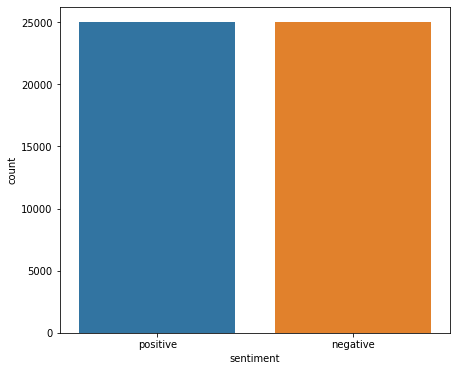

In [ ]:
fig = plt.figure(figsize=(7,6))
sns.countplot(df['sentiment'])

There are only two classes negative and positive.The class distribution above shows that their is an equal distribution of these reviews

**Number of words in a review**

Text(0.5, 1.0, 'Negative')

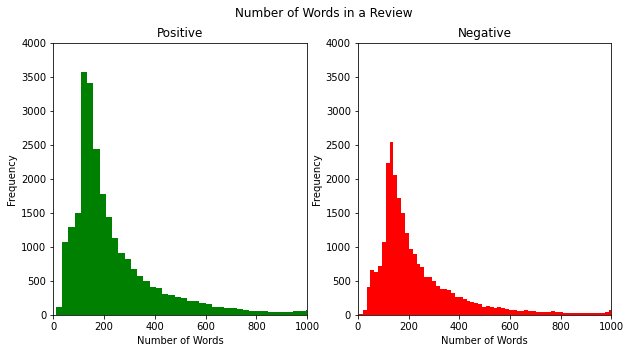

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
reviews = df[df['sentiment']=='positive']['review'].str.split().map(lambda x: len(x))
ax1.hist(reviews,100, color='green')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')
ax1.set_xlim(0, 1000)
ax1.set_ylim(0, 4000) 
ax1.set_title('Positive')
fig.suptitle('Number of Words in a Review')
reviews = df[df['sentiment']=='negative']['review'].str.split().map(lambda x: len(x))
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 4000) 
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')
ax2.hist(reviews,100, color='red')
ax2.set_title('Negative')
#Add same limits 

We can see that negative reviews have more number of words overall

##Data Cleaning

Some basic cleaning such as removing punctuations,removing html tags ,urls ,digits and emojis

**Helper functions for Data Cleaning**

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [ ]:
def remove_digits(text):
    text = re.sub(r"\d", "", text) # to remove digits
    return text

In [ ]:
# Removing Emojis from Dataset
df['review'] = df['review'].apply(lambda x: remove_emoji(x))
df['review']= df['review'].apply(lambda x : remove_URL(x))
df['review'] =  df['review'].apply(lambda x: remove_html(x))
df['review']= df['review'].apply(lambda x : remove_punct(x))
df['review']= df['review'].apply(lambda x : remove_digits(x))

In [ ]:
# Convert to Lower Case
df['review'] = df['review'].apply(lambda x: x.lower())

In [ ]:
df.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
5,probably my alltime favorite movie a story of ...,positive
6,i sure would like to see a resurrection of a u...,positive
7,this show was an amazing fresh innovative ide...,negative
8,encouraged by the positive comments about this...,negative
9,if you like original gut wrenching laughter yo...,positive


In [ ]:
labels_id = {'positive':1, 'negative':0 }
print(labels_id)

{'positive': 1, 'negative': 0}


In [ ]:
df['sentiment'].replace(labels_id,inplace=True)
df.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
5,probably my alltime favorite movie a story of ...,1
6,i sure would like to see a resurrection of a u...,1
7,this show was an amazing fresh innovative ide...,0
8,encouraged by the positive comments about this...,0
9,if you like original gut wrenching laughter yo...,1


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download("popular") #Install Multiple nltk packages

##Removing Stop words from Reviews Data

In [ ]:
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

no_stop_words_df = remove_stop_words(df['review'])

##Stemming Reviews Data

In [ ]:
def get_stemmed_text(corpus):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_df = get_stemmed_text(no_stop_words_df)

In [ ]:
stemmed_df[:5]

['one review mention watch oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom co

##Lemmatizing Reviews Data

In [ ]:
def get_lemmatized_text(corpus):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

preprocessed_df = get_lemmatized_text(stemmed_df)


In [ ]:
preprocessed_df[:5]

['one review mention watch oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom co

In [ ]:
df_preprocessed = DataFrame (preprocessed_df,columns=['review'])

#Machine Learning Techniques

### Creating a Bag of Word Model

Ref : https://machinelearningmastery.com/gentle-introduction-bag-words-model/

Ref : https://towardsdatascience.com/a-simple-explanation-of-the-bag-of-words-model-b88fc4f4971

Ref : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
vectorizer = CountVectorizer(max_features=7500)
#Create Bag of Words Model , here X represent bag of words, Y represents the label /target 
X = df_preprocessed['review'].values
Y = df['sentiment'].values   

### Split the training data in Train and Validation set

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X,Y,test_size=0.3, random_state=2020)

In [ ]:
print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

(35000,) (15000,) (35000,) (15000,)


In [ ]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
##BAG OF WORD
print(X_train.shape , X_test.shape)

(35000, 7500) (15000, 7500)


In [ ]:
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 19500 to 19530:\n{}".format(feature_names[19500:19530]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 7500
First 20 features:
['aaron', 'abandoned', 'abc', 'abilities', 'ability', 'able', 'aboard', 'abomination', 'abortion', 'abound', 'about', 'above', 'abraham', 'abrupt', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absorbing']
Features 19500 to 19530:
[]
Every 2000th feature:
['aaron', 'dropped', 'luke', 'showtime']


**Importing all Classifiers**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
df_AUC = pd.DataFrame( columns = ['Model Name', 'ROC AUC Score']) 

In [ ]:
df_AUC["Model Name"]

Series([], Name: Model Name, dtype: object)

### Gaussian Naive Bayes Model

In [ ]:
# Fitting Gaussian Naive Bayes to the Training set
classifier_gnb = GaussianNB()
classifier_gnb.fit(X_train.toarray(), y_train)
# Predicting the Train data set results
y_pred_gnb = classifier_gnb.predict(X_test.toarray())

# Classification Reports
report_gnb = classification_report(y_test, y_pred_gnb)
print(report_gnb)
y_auc = roc_auc_score(y_test, y_pred_gnb)
print('Gaussian Naive Bayes Model: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'Gaussian Naive Bayes', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.66      0.86      0.75      7474
           1       0.80      0.56      0.66      7526

    accuracy                           0.71     15000
   macro avg       0.73      0.71      0.70     15000
weighted avg       0.73      0.71      0.70     15000

Gaussian Naive Bayes Model: ROC AUC=0.710


### K-Nearest Neighbour

In [ ]:
# Fitting K- Nearest neighbour to the Training set
classifier_knn = KNeighborsClassifier(n_neighbors = 7, weights = 'distance',algorithm = 'brute')
classifier_knn.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_knn = classifier_knn.predict(X_test)
# Classification Reports
report_knn = classification_report(y_test, y_pred_knn)
print(report_knn)
y_auc = roc_auc_score(y_test, y_pred_knn)
print('K- Nearest neighbour: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':' K- Nearest neighbour', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      7474
           1       0.64      0.66      0.65      7526

    accuracy                           0.65     15000
   macro avg       0.65      0.65      0.65     15000
weighted avg       0.65      0.65      0.65     15000

K- Nearest neighbour: ROC AUC=0.648


### Decision Tree Classifier

In [ ]:
# Fitting Decision Tree Models to the Training set
classifier_dt = DecisionTreeClassifier(criterion= 'gini',
                                           max_depth = 10, 
                                           splitter='best', 
                                           random_state=55)
classifier_dt.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_dt = classifier_dt.predict(X_test)
# Classification Reports
report_dt = classification_report(y_test, y_pred_dt)
print(report_dt)
y_auc = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'Decision Tree', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.79      0.63      0.70      7474
           1       0.70      0.84      0.76      7526

    accuracy                           0.73     15000
   macro avg       0.74      0.73      0.73     15000
weighted avg       0.74      0.73      0.73     15000

Decision Tree: ROC AUC=0.734


### XGBoost Classifier

In [ ]:
# Fitting XGBoost Model to the Training set
classifier_xgb = XGBClassifier(max_depth=6,learning_rate=0.3,random_state=123,n_jobs=4)
classifier_xgb.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_xgb = classifier_xgb.predict(X_test)
# Classification Reports
report_xgb = classification_report(y_test, y_pred_xgb)
print(report_xgb)
y_auc = roc_auc_score(y_test, y_pred_xgb)
print('XGBoost Model: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'XGBoost', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      7474
           1       0.85      0.87      0.86      7526

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000

XGBoost Model: ROC AUC=0.858


### Multinomial Naive Bayes

In [ ]:
# Fitting multinomial naive bayes Model to the Training set
classifier_mnb = MultinomialNB()
classifier_mnb.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_mnb = classifier_mnb.predict(X_test)
# Classification Reports
report_mnb = classification_report(y_test, y_pred_mnb)
print(report_mnb)
y_auc = roc_auc_score(y_test, y_pred_mnb)
print('Multinomial naive bayes Model: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'Multinomial Naive bayes Model', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7474
           1       0.86      0.83      0.85      7526

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000

Multinomial naive bayes Model: ROC AUC=0.848


### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(max_depth=4,
                             random_state=100,
                             min_samples_leaf=100, 
                             min_samples_split=100,
                             n_estimators=50)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
# Classification Reports
report_rfc = classification_report(y_test, y_pred_rfc)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_rfc)
print('RandomForestClassifier: ROC AUC=%.3f' % (y_auc))
new_row = {'Model Name':'RandomForestClassifier', 'ROC AUC Score':y_auc }
df_AUC = df_AUC.append(new_row, ignore_index=True)

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      7474
           1       0.76      0.84      0.80      7526

    accuracy                           0.79     15000
   macro avg       0.79      0.79      0.79     15000
weighted avg       0.79      0.79      0.79     15000

RandomForestClassifier: ROC AUC=0.789


In [ ]:
df_AUC

,Model Name,ROC AUC Score
0,Gaussian Naive Bayes,0.709527
1,K- Nearest neighbour,0.647681
2,Decision Tree,0.734240
4,XGBoost,0.858480
5,Multinomial Naive bayes Model,0.847720
6,RandomForestClassifier,0.789284


##ROC Score Comparison of Various Classifiers

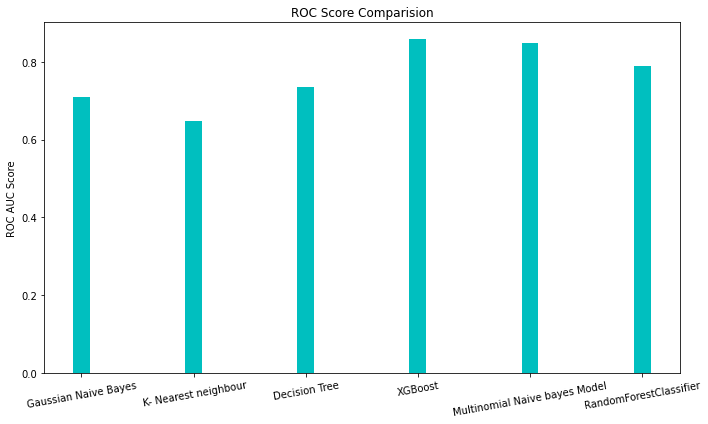

In [ ]:
fig=plt.figure(figsize=(10,6))
plt.bar(df_AUC["Model Name"], df_AUC["ROC AUC Score"],  color='c', width=.15)
#plt.ylim(1,40)
plt.xticks(rotation=10)
plt.ylabel('ROC AUC Score')
plt.title('ROC Score Comparision')
plt.tight_layout()

#Recurrent Neural Networks

##**GloVe for Vectorization**


Ref : https://nlp.stanford.edu/projects/glove/

Ref: https://medium.com/analytics-vidhyaword-vectorization-using-glove-76919685ee0b

Ref : https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

Creating Corpus for Glove.

In [ ]:
def create_corpus(df):
    corpus=[]
    for review in tqdm(df['review']):
        words=[word.lower() for word in word_tokenize(review) if((word.isalpha()==1) & (word.lower() not in english_stop_words))]
        corpus.append(words)
    return corpus

In [ ]:
 corpus_for_glove = create_corpus(df)

100%|██████████| 50000/50000 [01:03<00:00, 784.63it/s]


In [ ]:
print(corpus_for_glove[:5])

[['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly', 'happened', 'methe', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'wordit', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'manyaryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'moreso', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'awayi', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'wouldnt', 'dare', 'forget', 'pretty', 'pictures', 'painted', 'mainstream

In [ ]:
# Ref : https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-22 02:53:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-22 02:53:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-22 02:53:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

glove

In [ ]:
!unzip glove*.zip

In [ ]:
# Ref : https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning 
#Glove embedding is basically a file. So in first part, it just loads a file & separate word :
# vector value ( which is 100 D here)
embedding_dict={}
with open('/content/gdrive/My Drive/Colab Notebooks/Kaggle/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors 
f.close()

In [ ]:
#Ref : https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus_for_glove)
sequences=tokenizer_obj.texts_to_sequences(corpus_for_glove)

review_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 214157


In [ ]:
print(word_index)

In [ ]:
#We are trying to build embedding matrix ( as LSTM(Neural Network) models consume matrix in embedding layer )
#. Size of that matrix will be (number of unique words in corpus * 100 )
# We are just going over  each word and filling up our own embbeding matrix from the Glove embeddings. 
#If a word in given corpus is part of embedding dict of glove we got a hit & we can get corresponding vector from Glove.
# If there is no matching word in embedding dict
#then it's an embedding miss & that word will have default vector ( which is a vector of size 1 * 100 with all zeros)

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|██████████| 214157/214157 [00:00<00:00, 818137.37it/s]


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38251001,  0.14821   ,  0.60601002, ...,  0.058921  ,
         0.091112  ,  0.47283   ],
       [ 0.19915999, -0.049702  ,  0.24579   , ..., -0.068109  ,
         0.017651  ,  0.06455   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

##Split the available Data into Train and Test Set

In [ ]:
print(review_pad[1:])    # Padding of the train data is required to match with the embedding matrix

[[  275    38   249 ...   115    42  1736]
 [   96   275    26 ...  1245     3 18979]
 [  566   124   136 ...   713    10 10952]
 ...
 [ 3357  4097 41746 ...    13    36  3309]
 [   55    70  2830 ...  4594 10354    77]
 [    3  5510   230 ...   165  2134   870]]


In [ ]:
train=review_pad
train.shape

(50000, 50)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,df['sentiment'].values,test_size=0.20)
print('Shape of train',X_train.shape)
print("Shape of Test ",X_test.shape)

Shape of train (40000, 50)
Shape of Test  (10000, 50)


In [ ]:
print(y_train)

[1 0 0 ... 0 0 1]


##Model 1 - LSTM 

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           21415800  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 21,458,105
Trainable params: 42,305
Non-trainable params: 21,415,800
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16)

In [ ]:
BATCH_SIZE= 2000
EPOCHS = 1000
history=model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2,verbose=2, callbacks = [callback])

Epoch 1/1000
16/16 - 2s - loss: 0.7038 - accuracy: 0.4981 - val_loss: 0.7020 - val_accuracy: 0.4934
Epoch 2/1000
16/16 - 1s - loss: 0.7032 - accuracy: 0.4919 - val_loss: 0.7000 - val_accuracy: 0.4935
Epoch 3/1000
16/16 - 1s - loss: 0.7015 - accuracy: 0.4973 - val_loss: 0.6984 - val_accuracy: 0.4911
Epoch 4/1000
16/16 - 1s - loss: 0.6997 - accuracy: 0.4963 - val_loss: 0.6971 - val_accuracy: 0.4951
Epoch 5/1000
16/16 - 1s - loss: 0.6986 - accuracy: 0.5001 - val_loss: 0.6960 - val_accuracy: 0.5008
Epoch 6/1000
16/16 - 1s - loss: 0.6985 - accuracy: 0.4992 - val_loss: 0.6950 - val_accuracy: 0.5064
Epoch 7/1000
16/16 - 1s - loss: 0.6971 - accuracy: 0.5014 - val_loss: 0.6942 - val_accuracy: 0.5081
Epoch 8/1000
16/16 - 1s - loss: 0.6965 - accuracy: 0.5048 - val_loss: 0.6934 - val_accuracy: 0.5148
Epoch 9/1000
16/16 - 1s - loss: 0.6967 - accuracy: 0.5038 - val_loss: 0.6927 - val_accuracy: 0.5169
Epoch 10/1000
16/16 - 1s - loss: 0.6958 - accuracy: 0.5077 - val_loss: 0.6921 - val_accuracy: 0.5179

In [ ]:
#model.save('model1.h5')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,accuracy,val_loss,val_accuracy,epoch
448,0.519765,0.740469,0.511862,0.758625,448
449,0.520015,0.741219,0.511657,0.758625,449
450,0.519880,0.740656,0.511432,0.758750,450
451,0.513735,0.746063,0.511226,0.759375,451
452,0.517233,0.742969,0.513168,0.758500,452
453,0.519063,0.741156,0.513379,0.758500,453
454,0.517527,0.742500,0.511173,0.759875,454
455,0.518456,0.741375,0.510403,0.760500,455
456,0.516405,0.744531,0.512390,0.759750,456
457,0.517656,0.744094,0.511128,0.760375,457


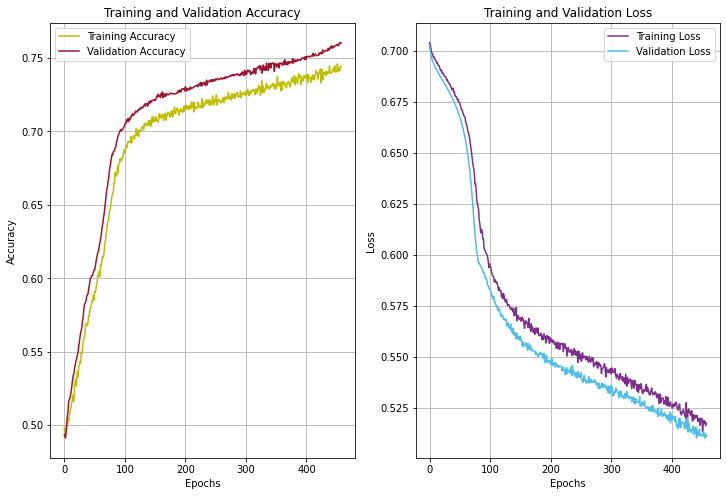

In [ ]:
epochs_range = range(458)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1840, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.3010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
#fig.savefig('TrainHistory_LSTM_1.pdf')

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

# test data for test_accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy*100))

Training Accuracy: 75.8700
Testing Accuracy:  75.4200


###Classification Report 

In [ ]:
##Predicting the Test Data
y_pred_lstm = model.predict(X_test)
#Rounding of the Probabilities 
y_pred_lstm_round = y_pred_lstm.round().astype('int')
# Classification Reports
report_rfc = classification_report(y_test, y_pred_lstm_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_lstm_round)
print('LSTM: ROC AUC=%.3f' % (y_auc))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73      5082
           1       0.71      0.85      0.77      4918

    accuracy                           0.75     10000
   macro avg       0.76      0.76      0.75     10000
weighted avg       0.76      0.75      0.75     10000

LSTM: ROC AUC=0.756


### ROC Curve 

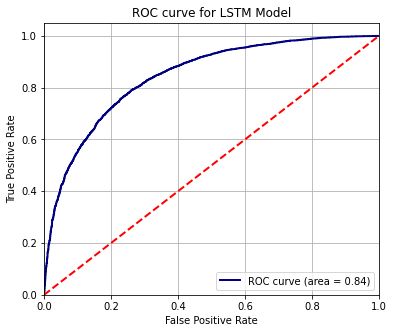

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_lstm)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for LSTM Model')
plt.legend(loc="lower right")
plt.show()
#fig.savefig('ROC_BiLSTM_83_1.pdf')

###Confusion Matrix

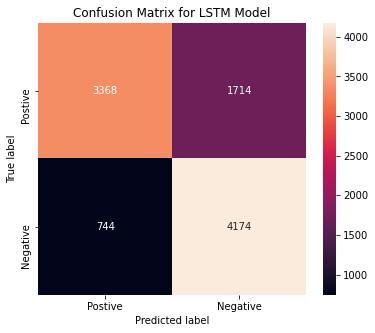

In [ ]:
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_pred_lstm_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

fig = plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix for LSTM Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
#fig.savefig('ConfusionMatrix_BiLSTM_final.pdf')

##Model 2 - Bidirectional LSTM 


In [ ]:
model_BiLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),                   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True, dropout = 0.6, recurrent_dropout = 0.6)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")    
])

model_BiLSTM.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

#define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16)


In [ ]:
model_BiLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           21415800  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           84480     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 21,501,321
Trainable params: 85,521
Non-trainable params: 21,415,800
_____________________________________

In [ ]:
history=model_BiLSTM.fit(X_train,y_train,batch_size=2000,epochs=1000,validation_split=0.15,verbose=1,callbacks = [callback])

Epoch 1/1000
17/17 [==============================] - 3s 174ms/step - loss: 0.7144 - acc: 0.5065 - val_loss: 0.6936 - val_acc: 0.4982
Epoch 2/1000
17/17 [==============================] - 2s 146ms/step - loss: 0.6941 - acc: 0.5299 - val_loss: 0.6842 - val_acc: 0.5590
Epoch 3/1000
17/17 [==============================] - 3s 153ms/step - loss: 0.6837 - acc: 0.5582 - val_loss: 0.6648 - val_acc: 0.6210
Epoch 4/1000
17/17 [==============================] - 3s 157ms/step - loss: 0.6616 - acc: 0.6056 - val_loss: 0.6174 - val_acc: 0.6867
Epoch 5/1000
17/17 [==============================] - 2s 141ms/step - loss: 0.6268 - acc: 0.6555 - val_loss: 0.5962 - val_acc: 0.6898
Epoch 6/1000
17/17 [==============================] - 3s 150ms/step - loss: 0.6087 - acc: 0.6753 - val_loss: 0.5765 - val_acc: 0.7068
Epoch 7/1000
17/17 [==============================] - 3s 149ms/step - loss: 0.5947 - acc: 0.6897 - val_loss: 0.5684 - val_acc: 0.7167
Epoch 8/1000
17/17 [==============================] - 3s 162ms

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,acc,val_loss,val_acc,epoch
101,0.458125,0.783529,0.434331,0.800333,101
102,0.457981,0.782971,0.443548,0.801000,102
103,0.462514,0.779647,0.440381,0.796000,103
104,0.458243,0.782618,0.434885,0.800000,104
105,0.455334,0.783176,0.432726,0.799333,105
106,0.454568,0.785912,0.438418,0.796500,106
107,0.456445,0.780971,0.441018,0.799167,107
108,0.458750,0.780647,0.431609,0.803333,108
109,0.454706,0.783265,0.434218,0.800833,109
110,0.455646,0.782500,0.437511,0.802500,110


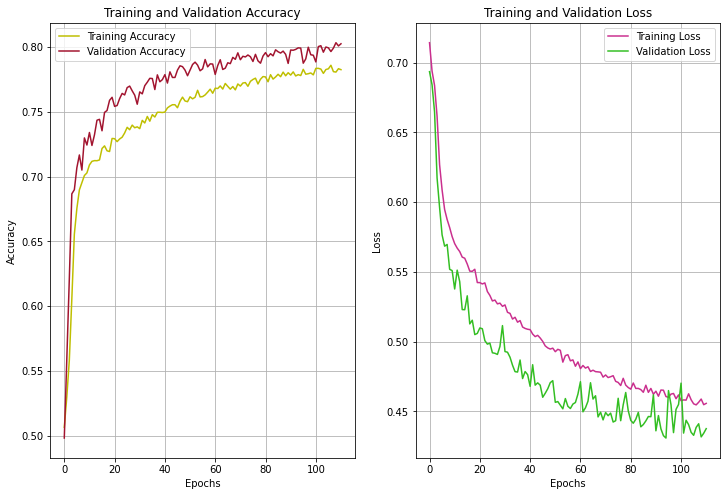

In [ ]:
epochs_range = range(111)# Where 111 is Total Number of Epochs during the training

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, hist['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, hist['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, hist['loss'], label='Training Loss', color=	[0.7940, 0.1850, 0.5560])
plt.plot(epochs_range, hist['val_loss'], label='Validation Loss', color= [0.2010, 0.7450, 0.1330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
#fig.savefig('TrainingHistory_BiLSTM_83.pdf')

In [ ]:

loss, accuracy = model_BiLSTM.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

# test data for test_accuracy
test_loss, test_accuracy = model_BiLSTM.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy*100))

Training Accuracy: 81.1050
Testing Accuracy:  80.3800


###Classification Report

In [ ]:
##Predicting the Test Data
y_pred_blstm = model_BiLSTM.predict(X_test)

#Rounding of the Probabilities 
y_pred_blstm_round = y_pred_blstm.round().astype('int')

# Classification Reports
report_rfc = classification_report(y_test, y_pred_blstm_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_blstm_round)
print('BiLSTM: ROC AUC=%.3f' % (y_auc))


              precision    recall  f1-score   support

           0       0.84      0.75      0.80      5082
           1       0.77      0.86      0.81      4918

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000

BiLSTM: ROC AUC=0.805


In [ ]:
y_test.shape

(10000,)

###ROC Curve

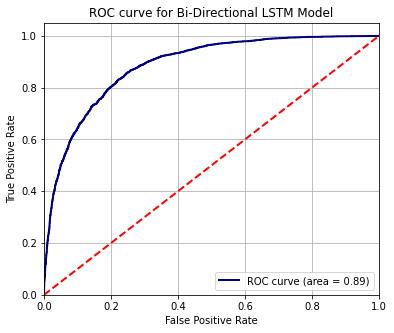

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_blstm)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(6, 5))
#plt.figure()
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for Bi-Directional LSTM Model')
plt.legend(loc="lower right")
plt.show()
#fig.savefig('ROC_BiLSTM_83_1.pdf')

###Confusion Matrix

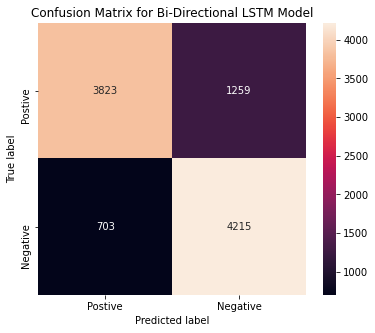

In [ ]:
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_pred_blstm_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

fig = plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix for Bi-Directional LSTM Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
#fig.savefig('ConfusionMatrix_BiLSTM_final.pdf')

In [ ]:
model_BiLSTM.save('biLSTM.h5')

##Model 3 - Gated Recurrent Unit

In [ ]:
model_GRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_matrix.shape[1], input_length = MAX_LEN, weights = [embedding_matrix],
                             trainable = False),   
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64 ,return_sequences=True,dropout = 0.4, recurrent_dropout = 0.4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64 ,return_sequences=True,dropout = 0.4, recurrent_dropout = 0.4)),   
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(units=1, activation="sigmoid")   
])

model_GRU.compile(loss = 'binary_crossentropy',  optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

#define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16)

In [ ]:
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           21415800  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           63744     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 128)           74496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 50, 32)            4128      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [ ]:
history=model_GRU.fit(X_train,y_train,batch_size=2000,epochs=1000,validation_split = .2,verbose=1,callbacks = [callback])

Epoch 1/1000
16/16 [==============================] - 5s 299ms/step - loss: 0.6808 - acc: 0.5700 - val_loss: 0.6360 - val_acc: 0.6633
Epoch 2/1000
16/16 [==============================] - 4s 243ms/step - loss: 0.6375 - acc: 0.6378 - val_loss: 0.6136 - val_acc: 0.6609
Epoch 3/1000
16/16 [==============================] - 4s 272ms/step - loss: 0.6098 - acc: 0.6681 - val_loss: 0.5772 - val_acc: 0.6998
Epoch 4/1000
16/16 [==============================] - 4s 255ms/step - loss: 0.5881 - acc: 0.6889 - val_loss: 0.5455 - val_acc: 0.7289
Epoch 5/1000
16/16 [==============================] - 4s 244ms/step - loss: 0.5706 - acc: 0.7060 - val_loss: 0.5402 - val_acc: 0.7289
Epoch 6/1000
16/16 [==============================] - 4s 264ms/step - loss: 0.5624 - acc: 0.7087 - val_loss: 0.5229 - val_acc: 0.7398
Epoch 7/1000
16/16 [==============================] - 4s 235ms/step - loss: 0.5580 - acc: 0.7140 - val_loss: 0.5240 - val_acc: 0.7390
Epoch 8/1000
16/16 [==============================] - 4s 242ms

In [ ]:
# Ref : https://stackoverflow.com/questions/51463383/buffered-data-was-truncated-after-reaching-the-output-size-limit
#model_GRU_7.save('model_GRU_7.h5')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,acc,val_loss,val_acc,epoch
269,0.356701,0.839938,0.378993,0.825250,269
270,0.356894,0.839500,0.381797,0.823750,270
271,0.355547,0.839281,0.386735,0.821500,271
272,0.357749,0.837969,0.379770,0.825875,272
273,0.354249,0.840219,0.385621,0.821375,273
274,0.354033,0.840844,0.395920,0.813625,274
275,0.356138,0.837687,0.391472,0.819375,275
276,0.355103,0.840906,0.388039,0.819875,276
277,0.351694,0.841250,0.382969,0.822375,277
278,0.354746,0.841187,0.400647,0.810500,278


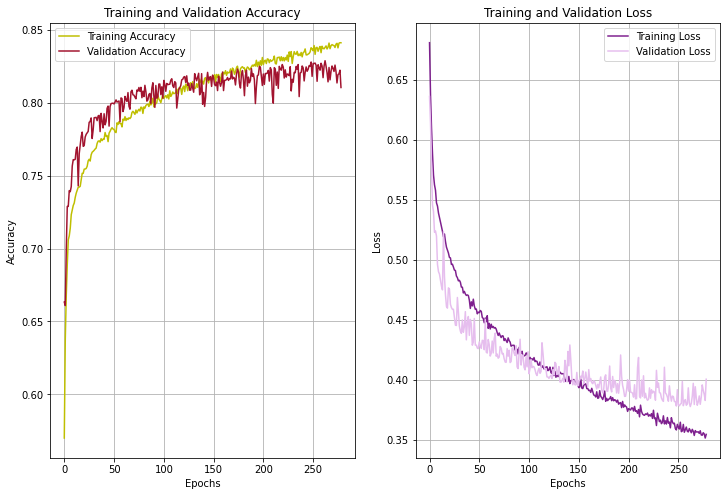

In [ ]:
epochs_range = range(279)

fig=plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['acc'], label='Training Accuracy', color=[0.75, 0.75, 0])
plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy', color= 	[0.6350, 0.0780, 0.1840])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color=	[0.4940, 0.1240, 0.5560])
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color= [0.9010, 0.7450, 0.9330])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()
#fig.savefig('TrainingHistory_GRU_3.pdf')

In [ ]:

loss, accuracy = model_GRU.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))


# test data for test_accuracy
test_loss, test_accuracy = model_GRU.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy*100))

Training Accuracy: 84.6950
Testing Accuracy:  80.7600


###Classification Report

In [ ]:
##Predicting the Test Data
y_pred_gru = model_GRU.predict(X_test)

#Rounding of the Probabilities 
y_pred_gru_round = y_pred_gru.round().astype('int')

# Classification Reports
report_rfc = classification_report(y_test, y_pred_gru_round)
print(report_rfc)
y_auc = roc_auc_score(y_test, y_pred_gru_round)
print('GRU: ROC AUC=%.3f' % (y_auc))


              precision    recall  f1-score   support

           0       0.77      0.89      0.82      5082
           1       0.86      0.73      0.79      4918

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

GRU: ROC AUC=0.806


###ROC Curve

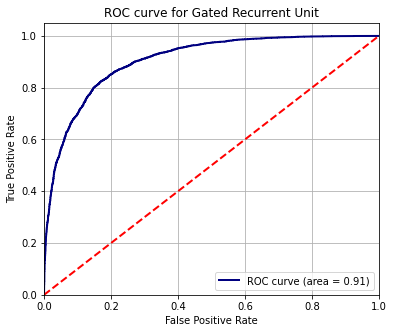

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_gru)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(6, 5))
#plt.figure()
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for Gated Recurrent Unit')
plt.legend(loc="lower right")
plt.show()
#fig.savefig('ROC_GRU.pdf')

###Confusion Matrix

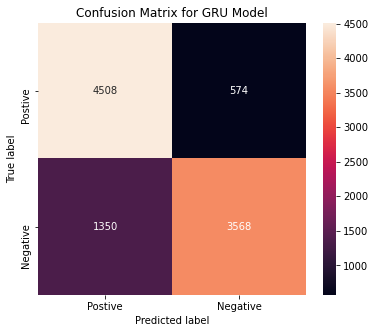

In [ ]:
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_pred_gru_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

fig = plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix for GRU Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
#fig.savefig('ConfusionMatrix_GRU.pdf')

#Transfer Learning for NLP


Ref: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

Ref : https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

Ref : http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

Ref : https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2

##Setting up BERT


Bidirectional Encoder Representations from Transformers (BERT) is a technique for NLP (Natural Language Processing) pre-training developed by Google. 
A pre-trained BERT model can be fine-tuned with just one additional output layer to create good models.

In [ ]:
##Importing Librarires 

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from tensorflow import keras

In [ ]:
# The official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 12.7MB/s 
     |████████████████████████████████| 2.9MB 63.6MB/s 
     |████████████████████████████████| 890kB 59.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=1a7cab32915797dd837c247d6cf0c8addebae6a2fc62df0e468dfe2bfbfc1ea0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly

     |████████████████████████████████| 112kB 13.9MB/s 
     |████████████████████████████████| 3.7MB 14.1MB/s 


##Model 4 - Using BERT 
Bidirectional Encoder Representations from Transformers

In [ ]:
#Ref Source for bert_encode function: https://www.kaggle.com/user123454321/bert-starter-inference
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

The BERT tokenizer does a pretty good preprocessing job by itself, 
therefore the input text is tokenized directly without any previous cleaning/preprocessing.

In [ ]:
train_df_master = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/IMDB Dataset.csv")

In [ ]:
train_df_master[5000:]

,review,sentiment
5000,"Not a movie for everyone, but this movie is in...",positive
5001,"This film is not your typical Hollywood fare, ...",positive
5002,RKO Radio Pictures made a real classic in 1947...,positive
5003,"""Transylvania 6-5000"" is an insignificant but ...",negative
5004,"This is a very good, under-rated action/drama/...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
labels_id = {'positive':1, 'negative':0 }
print(labels_id)

{'positive': 1, 'negative': 0}


In [ ]:
train_df_master['sentiment'].replace(labels_id,inplace=True)

In [ ]:
train= train_df_master[:35000]
test=train_df_master[35000:]

In [ ]:
print(train.shape)
print(test.shape)

(35000, 2)
(15000, 2)


In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
#module_url ="https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
#Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(train.review.values, tokenizer, max_len=160)
test_input = bert_encode(test.review.values, tokenizer, max_len=160)
train_labels = train.sentiment.values
test_labels = test.sentiment.values

In [ ]:
#Ref : https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
#Ref : https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2

max_len=160
input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

_, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
clf_output = sequence_output[:, 0, :]
out = Dense(1, activation='sigmoid')(clf_output)
    
model = Model([input_word_ids, input_mask, segment_ids], out)
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

The model configuration did not use any Dense layer. Simply added a sigmoid output directly to the last layer of BERT.

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
checkpoint = ModelCheckpoint('bert_model_23.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=2,
    callbacks=[checkpoint],
    batch_size=2
)

Epoch 1/2
14000/14000 [==============================] - 2549s 182ms/step - loss: 0.2793 - accuracy: 0.8867 - val_loss: 0.2526 - val_accuracy: 0.8903
Epoch 2/2
14000/14000 [==============================] - 2551s 182ms/step - loss: 0.1526 - accuracy: 0.9438 - val_loss: 0.2316 - val_accuracy: 0.9099


In [ ]:
import pandas as pd

hist = pd.DataFrame(train_history.history)
hist['epoch'] = train_history.epoch
hist.tail(15)

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.279306,0.886679,0.252583,0.890286,0
1,0.152566,0.943750,0.231648,0.909857,1


In [ ]:
# test data for test_accuracy
loss, accuracy = model.evaluate(train_input, train_labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

val_loss, val_accuracy = model.evaluate(test_input, test_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(val_accuracy*100))

Training Accuracy: 97.1686
Testing Accuracy:  91.0200


In [ ]:
test_pred = model.predict(test_input)
test_pred_BERT_int= test_pred.round().astype('int')

###Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_pred_BERT_int))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      7490
           1       0.92      0.90      0.91      7510

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000



In [ ]:
y_test = test_labels
y_score = test_pred

###ROC Curve

<Figure size 864x576 with 0 Axes>

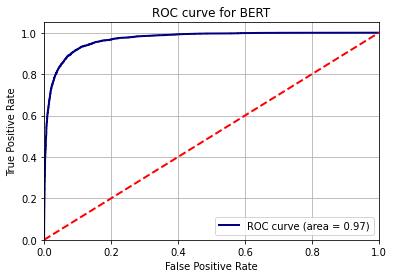

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_score)
roc_auc = auc(fpr, tpr)
fig=plt.figure(figsize=(12, 8))
plt.figure()
plt.plot(fpr, tpr, color= 'navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color= 'red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for BERT')
plt.legend(loc="lower right")
plt.show()
#fig.savefig('ROC_BERT.pdf')

###Confusion Matrix

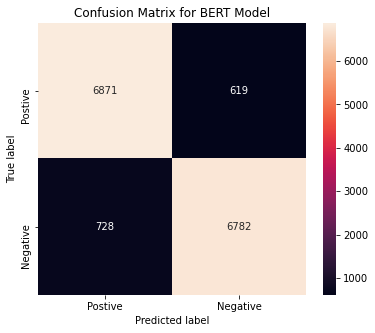

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
y_score_round = y_score.round().astype('int')
# Creates a confusion matrix
cm = confusion_matrix(y_test,y_score_round) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Postive','Negative'], 
                     columns = ['Postive','Negative'])

fig = plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix for BERT Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
#fig.savefig('ConfusionMatrix_BERT.pdf')

In [ ]:
model.save('BERT_sentiment.h5')

#Key References



Ref : https://machinelearningmastery.com/gentle-introduction-bag-words-model/

Ref : https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221

Ref : https://towardsdatascience.com/a-simple-explanation-of-the-bag-of-words-model-b88fc4f4971

Ref : https://nlp.stanford.edu/projects/glove/

Ref: https://medium.com/analytics-vidhyaword-vectorization-using-glove-76919685ee0b

Ref : https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

Ref : https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm

Ref: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

Ref : https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

Ref : http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

Ref : https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2

Ref:https://www.kaggle.com/user123454321/bert-starter-inference